## This is the script to make qualitative results of all models. Take the single frame and model path file as input then output the results images.

## This is similar to the python script 'visual_run.py' in home folder. If you want to execute images in batches, please refer to that script.

In [1]:
import os
import cv2
import sys
import json
import time
import torch
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

/home/autolab/miniconda3/envs/conda_clft_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append(os.path.abspath('../'))

In [4]:
from clft.clft import CLFT
from clfcn.fusion_net import FusionNet
from utils.helpers import waymo_anno_class_relabel
from utils.lidar_process import open_lidar
from utils.lidar_process import crop_pointcloud
from utils.lidar_process import get_unresized_lid_img_val
from iseauto.dataset import lidar_dilation

from utils.helpers import draw_test_segmentation_map
from utils.metrics import find_overlap
from utils.metrics import auc_ap

In [32]:
class OpenInput(object):
    def __init__(self, cam_mean, cam_std, lidar_mean, lidar_std, w_ratio, h_ratio):
        self.cam_mean = cam_mean
        self.cam_std = cam_std
        self.lidar_mean = lidar_mean
        self.lidar_std = lidar_std
        self.w_ratio = w_ratio
        self.h_ratio = h_ratio

    def open_rgb(self, image_path):
        rgb_normalize = transforms.Compose(
            [transforms.Resize((384, 384),
                    interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=self.cam_mean,
                    std=self.cam_std)])

        rgb = Image.open(image_path).convert('RGB')
        # image = Image.open(
        #       '/home/claude/Data/claude_iseauto/labeled/night_fair/rgb/sq14_000061.png').\
        #         resize((480, 320)).convert('RGB')
        w_orig, h_orig = rgb.size  # original image's w and h
        delta = int(h_orig/2)
        top_crop_rgb = TF.crop(rgb, delta, 0, h_orig-delta, w_orig)
        top_rgb_norm = rgb_normalize(top_crop_rgb)
        return top_rgb_norm

    def open_anno(self, anno_path):
        anno_resize = transforms.Resize((384, 384),
                        interpolation=transforms.InterpolationMode.NEAREST)
        anno = Image.open(anno_path)
        anno = waymo_anno_class_relabel(anno)
        # annotation = Image.open(
        #       '/home/claude/Data/claude_iseauto/labeled/night_fair/annotation_rgb/sq14_000061.png').\
        #          resize((480, 320), Image.BICUBIC).convert('F')
        w_orig, h_orig = anno.size  # PIL tuple. (w, h)
        delta = int(h_orig/2)
        top_crop_anno = TF.crop(anno, delta, 0, h_orig - delta, w_orig)
        anno_resize = anno_resize(top_crop_anno).squeeze(0)
        return anno_resize

    def open_lidar(self, lidar_path):
        points_set, camera_coord = open_lidar(
           lidar_path,
            w_ratio=self.w_ratio,
            h_ratio=self.h_ratio,
            lidar_mean=self.lidar_mean,
            lidar_std=self.lidar_std)

        top_crop_points_set, top_crop_camera_coord, _ = crop_pointcloud(
            points_set, camera_coord, 160, 0, 160, 480)
        X, Y, Z = get_unresized_lid_img_val(160, 480,
                                            top_crop_points_set,
                                            top_crop_camera_coord)
        X, Y, Z = lidar_dilation(X, Y, Z)
        X = transforms.Resize((384, 384))(X)
        Y = transforms.Resize((384, 384))(Y)
        Z = transforms.Resize((384, 384))(Z)

        X = TF.to_tensor(np.array(X))
        Y = TF.to_tensor(np.array(Y))
        Z = TF.to_tensor(np.array(Z))

        lid_images = torch.cat((X, Y, Z), 0)
        return lid_images

In [33]:
# As we only make one image output, will use cpu here. 
device = torch.device("cpu")

In [ ]:
# initiate the CLFT-Hybrid model, becuase model_timm="vit_base_resnet50_384" and path_size = 16, also be careful emb_dim is 768 
# for CLFT-hybird, 1024 for CLFT-Large.
resize = 384
model = DPT(
    RGB_tensor_size=(3, resize, resize),
    XYZ_tensor_size=(3, resize, resize),
    emb_dim=768,
    resample_dim=256,
    read="projection",
    nclasses=4,
    hooks=[2, 5, 8, 11],
    model_timm="vit_base_resnet50_384",   
    type="segmentation",
    patch_size=16,)
model_path = '../clft_hybird_fusion_checkpoint_374.pth'
model.load_state_dict(torch.load(model_path, map_location=device)[
                              'model_state_dict'])

model.to(device)
model.eval()

In [35]:
#here need to give all these information. These numners are for Waymo dataset
open_input = OpenInput(cam_mean=[0.485, 0.456, 0.406], 
                       cam_std=[0.229, 0.224, 0.225], 
                       lidar_mean=[-0.17263354, 0.85321806, 24.5527253], 
                       lidar_std=[7.34546552, 1.17227659, 15.83745082], 
                       w_ratio=4, 
                       h_ratio=4)

In [36]:
waymo_all_list = open('/home/autolab/Data/waymo/splits_clft/all.txt', 'r')
waymo_all_cam = np.array(waymo_all_list.read().splitlines())
waymo_all_list.close()
print(waymo_all_cam[0])

labeled/night/rain/camera/segment-427564647064237172_183_000_203_000_0000000198.png


In [62]:
dataroot = '/home/autolab/Data/waymo/'
for i in waymo_all_cam:
    cam_path = os.path.join(dataroot, i)
    anno_path = cam_path.replace('/camera', '/annotation')
    lidar_path = cam_path.replace('/camera', '/lidar').replace('.png', '.pkl')

    rgb_name = cam_path.split('/')[-1].split('.')[0]
    anno_name = anno_path.split('/')[-1].split('.')[0]
    lidar_name = lidar_path.split('/')[-1].split('.')[0]
    assert (rgb_name == lidar_name)
    assert (anno_name == lidar_name)

    rgb = open_input.open_rgb(cam_path).to(device, non_blocking=True)
    rgb = rgb.unsqueeze(0)  # add a batch dimension
    lidar = open_input.open_lidar(lidar_path).to(device, non_blocking=True)
    lidar = lidar.unsqueeze(0)

    with torch.no_grad():
        _, output_seg = model(rgb, lidar, 'cross_fusion')
        segmented_image = draw_test_segmentation_map(output_seg)
        seg_resize = cv2.resize(segmented_image, (480, 160))

    

    seg_path = cam_path.replace('waymo/labeled', 'clft_seg_results/hybird_fusion/segment')
    overlay_path = cam_path.replace('waymo/labeled', 'clft_seg_results/hybird_fusion/overlay')
    cv2.imwrite(seg_path ,seg_resize)
    
    rgb_cv2 = cv2.imread(cam_path)
    rgb_cv2_top = rgb_cv2[160:320, 0:480]
    overlay = image_overlay(rgb_cv2_top, seg_resize)
    cv2.imwrite(overlay_path, overlay)
    
    break

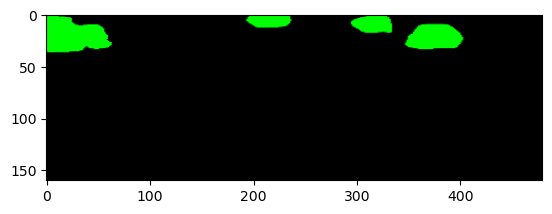

In [56]:
plt.imshow(seg_resize)

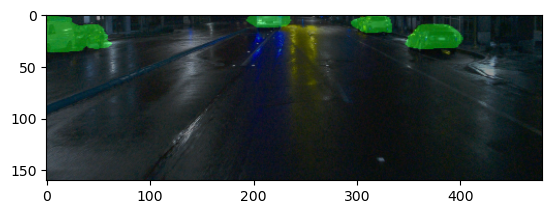

In [60]:
cv2.imwrite(seg_path, overlay)
plt.imshow(overlay)

In [49]:
seg_resize.shape

(160, 480, 3)

In [5]:
def image_overlay(image, segmented_image):
    alpha = 0.4  # how much transparency to apply
    beta = 1 - alpha  # alpha + beta should equal 1
    gamma = 0  # scalar added to each sum
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #segmented_image = np.array(segmented_image)
    #segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(segmented_image, alpha, image, beta, gamma, image)
    return image

In [90]:
rgb = open_input.open_rgb('../test_images/test_1_img.png').to(device, non_blocking=True)
rgb = rgb.unsqueeze(0)  # add a batch dimension
lidar = open_input.open_lidar('../test_images/test_1_lidar.pkl').to(device, non_blocking=True)
lidar = lidar.unsqueeze(0)

In [91]:
# mauually put 'rgb' 'lidar' 'cross_fusion' here. 
with torch.no_grad():
    _, output_seg = model(rgb, lidar, 'cross_fusion')
segmented_image = draw_test_segmentation_map(output_seg)
seg_resize = cv2.resize(segmented_image, (480, 160))

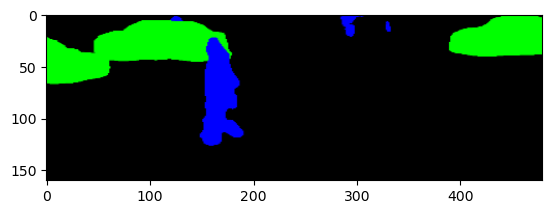

In [92]:
#cv2.imwrite('./dpt_seg_visual.png',seg_resize)
plt.imshow(seg_resize)

In [93]:
rgb = cv2.imread('../test_images/test_1_img.png')
rgb_top = rgb[160:320, 0:480]
seg = cv2.imread('./dpt_seg_visual.png')
overlay = image_overlay(rgb_top, seg)

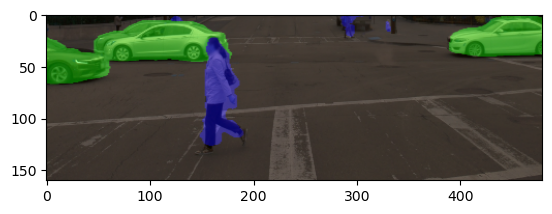

In [94]:
#cv2.imwrite('./overlay.png',cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.imshow(overlay)

In [96]:
seg.dtype

dtype('uint8')

In [25]:
asd = np.where(im != [0, 0, 0])

In [23]:
asd

(array([], dtype=int64),)

In [35]:
from glob import glob

In [43]:
df_path = glob('/home/autolab/Data/panoptic_seg_results/camera_mode/seg_day_rain/*.png')

In [44]:
for seg_path in df_path:
    rgb_path = seg_path.replace('panoptic_seg_results/camera_mode/seg_day_rain', 'waymo/labeled/day/rain/camera')
    overlay_path = seg_path.replace('seg_day_rain', 'overlay_day_rain')
    
    panop_seg = cv2.imread(seg_path)
    rgb = cv2.imread(rgb_path)

    mask_human = np.where(np.all(panop_seg == [142, 0, 0],axis=2))
    mask_car = np.where(np.all(panop_seg == [32, 11,119],axis=2))

    panop_seg[mask_car[0], mask_car[1]] = [0,255,0]
    panop_seg[mask_human[0], mask_human[1]] = [0,0,255]

    mask_human = np.where(np.all(panop_seg == [85, 0, 102],axis=2))
    mask_car = np.where(np.all(panop_seg == [19, 109,71],axis=2))

    panop_seg[mask_car[0], mask_car[1]] = [0,255,0]
    panop_seg[mask_human[0], mask_human[1]] = [0,0,255]

    panop_overlay = image_overlay(rgb, panop_seg)    
    cv2.imwrite(overlay_path, panop_overlay)

In [248]:
a = cv2.imread('/home/autolab/Data/panoptic_seg_results/camera_mode/seg_day_rain/segment-16102220208346880_1420_000_1440_000_with_camera_labels_0000000021.png')

In [249]:
mask_human = np.where(np.all(panop_seg == [142, 0, 0],axis=2))
mask_car = np.where(np.all(panop_seg == [32, 11,119],axis=2))

# panop_seg[mask_car] = [0, 255,0]
# panop_seg[mask_human] = [0,0,255]

In [250]:
mask_car

(array([149, 149, 149, ..., 293, 293, 293]),
 array([451, 452, 453, ..., 233, 234, 235]))

In [251]:
panop_seg[mask_car[0], mask_car[1]] = [0,255,0]
panop_seg[mask_human[0], mask_human[1]] = [0,0,255]

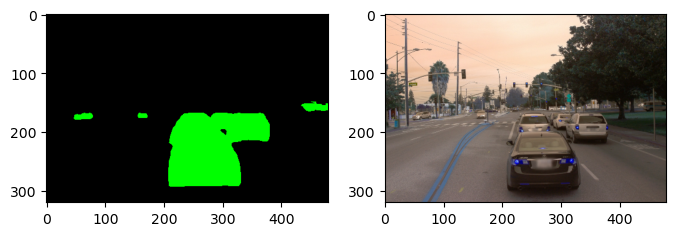

In [252]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1) 
plt.imshow(panop_seg)
fig.add_subplot(1, 2, 2)
plt.imshow(rgb)

In [253]:
panop_overlay = image_overlay(rgb, panop_seg)

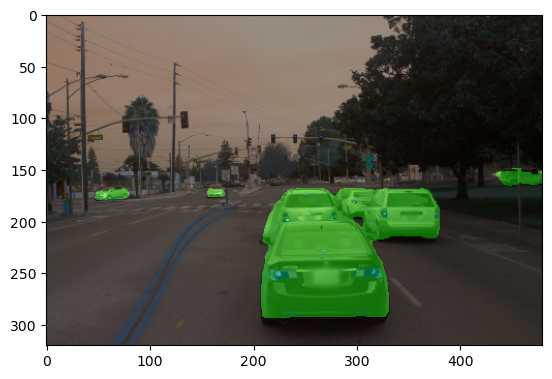

In [254]:
cv2.imwrite(overlay_path, panop_overlay)
plt.imshow(panop_overlay)

In [77]:
waymo_rgb = cv2.imread('/home/autolab/Data/waymo/labeled/night/rain/camera/segment-9320169289978396279_1040_000_1060_000_with_camera_labels_0000000197.png')

In [79]:
waymo_anno = cv2.imread('/home/autolab/Data/waymo/labeled/night/rain/annotation_relabel_rgb/segment-9320169289978396279_1040_000_1060_000_with_camera_labels_0000000197.png')

In [80]:
mask_0 = np.where(np.all(waymo_anno == [0, 0, 0],axis=2))
mask_1 = np.where(np.all(waymo_anno == [1, 1, 1],axis=2))
mask_2 = np.where(np.all(waymo_anno == [2, 2, 2],axis=2))
mask_3 = np.where(np.all(waymo_anno == [3, 3, 3],axis=2))

In [81]:
waymo_anno[mask_0[0], mask_0[1]] = [0,0,0]
waymo_anno[mask_1[0], mask_1[1]] = [0,255,0]
waymo_anno[mask_2[0], mask_2[1]] = [0,0,255]
waymo_anno[mask_3[0], mask_3[1]] = [0,0,0]

In [82]:
ol = image_overlay(waymo_rgb, waymo_anno)

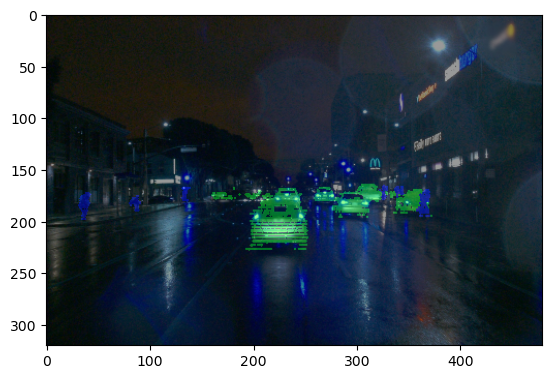

In [84]:
cv2.imwrite('night_rain_ovelay.png', ol)
plt.imshow(ol)